In [1]:
import numpy as np
from numpy.linalg import norm # TO calculate norm of a vector
import pickle 
from tqdm.notebook import tqdm
import os
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [2]:
# Load MobileNet V2 model
model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg',
)

2022-11-01 16:12:48.506289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-01 16:12:48.506331: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


94668760/94668760 [==============================] - 2s 0us/step


In [3]:
# Function to load, preprocess images and extract the features
def extract_features(img_path, model):
  input_shape = (224,224,3)
  img = image.load_img(
      img_path,
      target_size = (input_shape[0], input_shape[1]),
  )

  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img, verbose=0)
  flattened_features = features.flatten()
  normalized_features = flattened_features/norm(flattened_features)
  return normalized_features

In [5]:
features = extract_features("../../caltech_256/003.backpack/003_0003.jpg", model)

In [6]:
print(len(features))

2048


In [7]:
extensions =  ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

In [8]:
def get_file_list(root_dir):
  file_list = []
  counter = 1

  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      if any(ext in filename for ext in extensions):
        file_list.append(os.path.join(root,filename))
        counter += 1
  return file_list


In [9]:
root_dir = "../../caltech_256/"
filenames = sorted(get_file_list(root_dir))

In [ ]:
feature_list = []

for i in tqdm(range(len(filenames))):
  feature_list.append(extract_features(filenames[i], model))

pickle.dump(feature_list, open("features-caltech256-resnet.pickle", "wb"))
pickle.dump(filenames, open("filenames-caltech256-resnet.pickle", "wb"))

  0%|          | 0/30608 [00:00<?, ?it/s]

In [ ]:
filenames = np.array(pickle.load(open("filenames-caltech256-resnet.pickle", "rb")))
feature_list = np.array(pickle.load(open("features-caltech256-resnet.pickle", "rb")))

## Reducing Dimensions with PCA

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [66]:
num_dimensions = 100
pca = PCA(n_components = num_dimensions)

In [67]:
pca.fit(feature_list)

PCA(n_components=100)

In [68]:
feature_list_compressed = pca.transform(feature_list)

In [73]:
print(feature_list_compressed.shape)
print(pca.explained_variance_ratio_)

(8677, 100)
[0.0659596  0.05561303 0.0451963  0.02646794 0.01969231 0.01760776
 0.01704922 0.01498693 0.01447718 0.01297559 0.01276003 0.01185677
 0.01120538 0.01064481 0.01018625 0.00967055 0.00955486 0.00944066
 0.00841735 0.00835091 0.00784477 0.00782997 0.00736397 0.00729609
 0.00693018 0.00675652 0.00660976 0.00649518 0.00641216 0.0063299
 0.00617593 0.00594758 0.00589329 0.0056707  0.00539149 0.00534759
 0.00517591 0.00504234 0.00488525 0.00480829 0.00463524 0.00454966
 0.00447954 0.00440346 0.00437756 0.00420852 0.00409042 0.00398304
 0.00387428 0.00378806 0.00368756 0.00363441 0.00357844 0.0034899
 0.00345186 0.00338908 0.00332044 0.00324876 0.00321193 0.00312624
 0.00303542 0.00300941 0.00293828 0.00291387 0.00288028 0.00278973
 0.00278737 0.00272559 0.00266781 0.00266032 0.00261308 0.00257309
 0.00248372 0.00247889 0.00242909 0.00238427 0.0023656  0.00232864
 0.0023023  0.00226383 0.0022122  0.00217636 0.00215516 0.00213341
 0.00210179 0.00207985 0.00204708 0.0020296  0.00201

## Why we chose only 100 features in the above PCA.

In the below graph, we chose the number of componenets in the pca to be 200. As we can
see that after 100 componenets,  the difference in the variance is minmal. So choosing 100
componenets is a sweet spot in terms of computation and the number of features.
The individual variance will tell us how important the newly added features are. For
example, after the first 100 dimensions, the additional dimensions don’t add much
variance (almost equal to 0) and can be neglected.


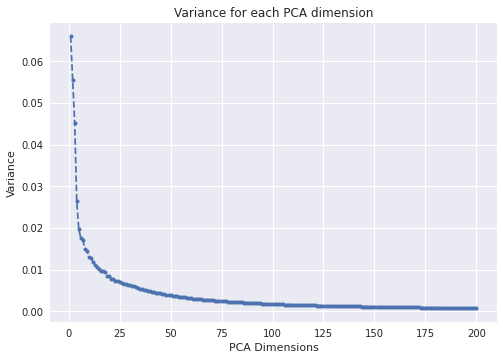

In [77]:
pca = PCA(200)
pca.fit(feature_list)
plt.style.use('seaborn')
plt.plot(range(1,201),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

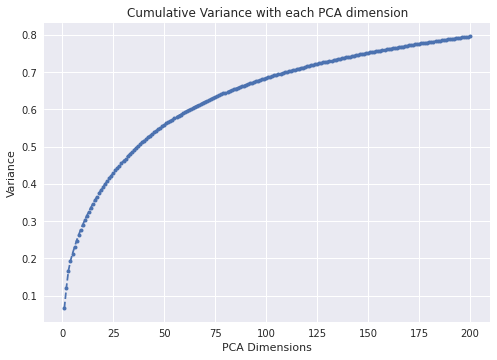

In [78]:
plt.plot(range(1,201),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4)
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

The number of dimensions in PCA is an important parameter that we can tune to the
problem at hand. One way to directly justify a good threshold is to find a good bal‐
ance between the number of features and its effect on accuracy versus speed:

In [91]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]

In [92]:
# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [93]:
pca_dimensions = [1,2,3,4,5,10,20,50,75,100,150,200]
pca_accuracy = []
pca_time = []
for dimensions in pca_dimensions:
    # Perform PCA
    pca = PCA(n_components = dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, time_taken = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(time_taken)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ",accuracy,"%",
    ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  22.81 % ,	Time =  6.146492958068848
For PCA Dimensions =  2 ,	Accuracy =  28.35 % ,	Time =  6.817043781280518
For PCA Dimensions =  3 ,	Accuracy =  33.26 % ,	Time =  6.877553462982178
For PCA Dimensions =  4 ,	Accuracy =  41.9 % ,	Time =  7.007089138031006
For PCA Dimensions =  5 ,	Accuracy =  48.67 % ,	Time =  7.143710374832153
For PCA Dimensions =  10 ,	Accuracy =  69.36 % ,	Time =  16.367141723632812
For PCA Dimensions =  20 ,	Accuracy =  80.38 % ,	Time =  17.447949409484863
For PCA Dimensions =  50 ,	Accuracy =  86.47 % ,	Time =  27.549829244613647
For PCA Dimensions =  75 ,	Accuracy =  88.35 % ,	Time =  33.48862385749817
For PCA Dimensions =  100 ,	Accuracy =  88.94 % ,	Time =  45.46833801269531
For PCA Dimensions =  150 ,	Accuracy =  89.14 % ,	Time =  61.66461372375488
For PCA Dimensions =  200 ,	Accuracy =  89.11 % ,	Time =  80.97681045532227


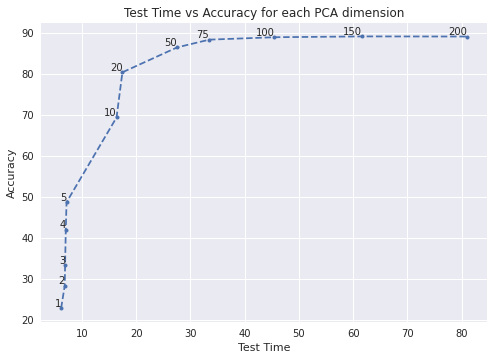

In [95]:
plt.plot(pca_time, pca_accuracy,'o--', markersize=4)
for label, x, y in zip(pca_dimensions, pca_time,pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
    plt.title ('Test Time vs Accuracy for each PCA dimension')
    plt.xlabel('Test Time')
    plt.ylabel('Accuracy')
    plt.grid(True)
plt.show()

As is visible in the graph, there is little improvement in accuracy after increasing
beyond a feature-length of 100 dimensions. With almost 20 times fewer dimensions
(100) than the original (2,048), this offers drastically higher speed and less time on
almost any search algorithm, while achieving similar (and sometimes slightly better)
accuracy. Hence, 100 would be an ideal feature-length for this dataset. This also
means that the first 100 dimensions contain the most information about the dataset.

## Visualize clusters

In [97]:
from sklearn.manifold import TSNE

In [100]:
# Perform PCA over the features
num_feature_dimensions=100
# Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


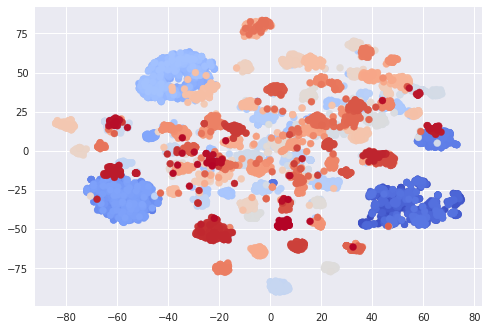

In [101]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
tsne_transformed = tsne.fit_transform(feature_list)
class_ids = os.listdir("/notebooks/caltech_101")
colormap = plt.cm.get_cmap('coolwarm')
plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], cmap=colormap, c=[i for i in range(feature_list.shape[0])])

## Similarity search using ANN (Approximate Nearest Neighbours) instead of KNN for faster searches and scalability

Available Libraries:
- Spotify’s Annoy
- FLANN, Facebook’s Faiss
- Yahoo’s NGT
- NMSLIB

> We will be using Annoy

In [102]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 kB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp39-cp39-linux_x86_64.whl size=582273 sha256=e147a6a519d010b413ee3d10e1d5efe38c3c3086829756f8db4c67dcf39f54c7
  Stored in directory: /root/.cache/pip/wheels/5b/7d/31/9a9a4993d085bc85bee21946bce94cd5906ce99730f5467e57
Successfully built annoy


First, we build a search index with two hyperparame‐ters: the number of dimensions of the dataset and the number of trees:

In [105]:
from annoy import AnnoyIndex
num_dimensions = 100 # The number of componenets in PCA
anoy_index = AnnoyIndex(num_dimensions, metric='angular')

## Selecting the best number of trees for annoy

In [113]:
import random
# Choose a random image to experiment
random_image_index = random.randint(0, len(filenames))
# Note: the results may change if the image is changed

annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300
]
for num_trees in annoy_trees:
    t = AnnoyIndex(2048)  # Length of item vector that will be indexed
    for i in range(len(filenames)):
        feature = feature_list[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees)  #50 trees
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    start_time = time.time()
    indices = t.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
    end_time = time.time()
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

/tmp/ipykernel_32/2176911311.py:12: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(2048)  # Length of item vector that will be indexed


For number of trees =  1 ,	Time to train =  0.02437448501586914 ,	Time to test =  0.0018002986907958984
For number of trees =  2 ,	Time to train =  0.021434783935546875 ,	Time to test =  0.0017693042755126953
For number of trees =  3 ,	Time to train =  0.02745985984802246 ,	Time to test =  0.0015225410461425781
For number of trees =  4 ,	Time to train =  0.03936195373535156 ,	Time to test =  0.0017924308776855469
For number of trees =  5 ,	Time to train =  0.02998495101928711 ,	Time to test =  0.0019321441650390625
For number of trees =  10 ,	Time to train =  0.07079648971557617 ,	Time to test =  0.001813650131225586
For number of trees =  20 ,	Time to train =  0.09131407737731934 ,	Time to test =  0.0012693405151367188
For number of trees =  30 ,	Time to train =  0.15137839317321777 ,	Time to test =  0.0014126300811767578
For number of trees =  40 ,	Time to train =  0.19833827018737793 ,	Time to test =  0.0010116100311279297
For number of trees =  50 ,	Time to train =  0.2430233955383

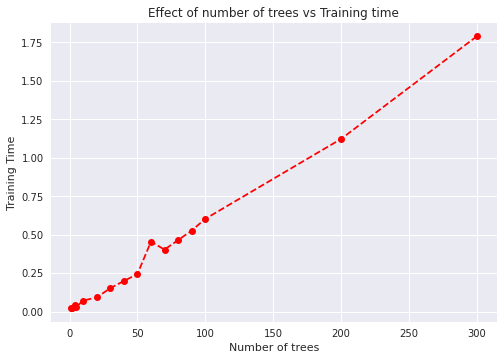

In [114]:
plt.plot(annoy_trees, annoy_training_time, 'or--')
plt.title('Effect of number of trees vs Training time')
plt.xlabel('Number of trees')
plt.ylabel('Training Time')
plt.grid(True)
plt.show()

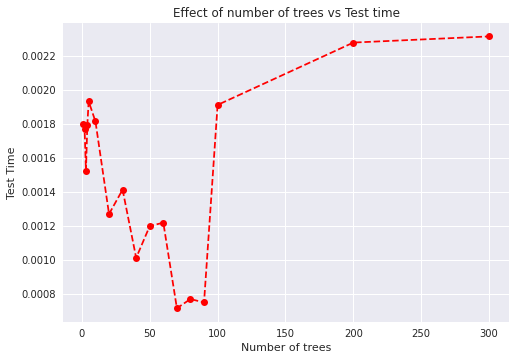

In [115]:
plt.plot(annoy_trees, annoy_test_time, 'or--')
plt.title('Effect of number of trees vs Test time')
plt.xlabel('Number of trees')
plt.ylabel('Test Time')
plt.grid(True)
plt.show()

## We'll choose 100 trees for now

In [122]:
num_trees = 100

anoy_index = AnnoyIndex(num_dimensions, metric='angular')

In [123]:
for i in range(len(filenames)):
    anoy_index.add_item(i, feature_list_compressed[i])

In [124]:
anoy_index.build(num_trees)

True

In [209]:
search_img_path = filenames[np.random.randint(len(filenames))]
query = extract_features(search_img_path, model)
query = pca.transform(np.expand_dims(query, axis=0))
print(query.shape)

(1, 100)


In [210]:
anoy_search = anoy_index.get_nns_by_vector(query[0], 6, include_distances=True)

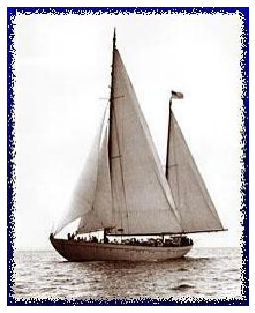

In [211]:
plt.imshow(mpimg.imread(search_img_path))
plt.axis('off')
plt.show()

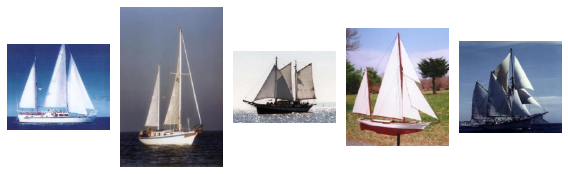

In [212]:
import matplotlib.image as mpimg

fig, ax = plt.subplots(1,5)

for i in range(len(anoy_search[0])-1):
    ax[i].imshow(mpimg.imread(filenames[anoy_search[0][i+1]]))
    ax[i].set_axis_off()
    

fig.tight_layout()              
fig.show()